In [184]:
import numpy as np
import torch
from torch import optim
from torch import distributions as dist
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plot.plot_hist_loss import plot_loss
from simulate.simulate import simulate
from inference.flows import NormalizingFlow
from inference.loss import LossTeaching

In [185]:
sns.set()

In [186]:
%config InlineBackend.figure_format = "retina"

In [187]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.log_var = torch.nn.Parameter(torch.zeros(1))
        self.mu = torch.nn.Parameter(torch.zeros(1))
    
    def forward(self, obs):

        mu, log_var = self.mu, self.log_var
        sigma = torch.exp(0.5 * log_var)
        lls =  dist.Normal(mu, sigma).log_prob(obs)
        return - lls.mean()

In [188]:
def plot_results(mu_samples, log_var_samples, 
                 obs_mu, obs_sigma, 
                 true_mu, true_sigma,
                 alpha_scatter=1.0, 
                 alpha_pdf=1.0):
    
    true_log_var = np.log(true_sigma**2)
    obs_log_var = np.log(obs_sigma**2)
    
    sigma_samples = torch.exp(0.5*log_var_samples)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

    ax=axes[0]
    ax.set_title("Unconstrained space")
    ax.scatter(mu_samples, log_var_samples, alpha=alpha_scatter, 
               color="C1", s=80,
               label='inferred')
    ax.scatter(true_mu, true_log_var, label="theoretic", facecolors='none', edgecolors='C0', s=80,
               linewidths=1,)
    ax.scatter(obs_mu, obs_log_var, label="observed", facecolors='none', edgecolors='C0', s=80,
               linewidths=3,)
    ax.set_xlabel("$\mu$")
    ax.set_ylabel("$\ln \sigma^2$")
    ax.legend()

    ax=axes[1]
    x = torch.linspace(-2, 10, 100).unsqueeze(0)
    
    pdf_true = dist.Normal(true_mu, true_sigma).log_prob(x).exp()
    pdf_sample = dist.Normal(mu_samples, sigma_samples).log_prob(x.unsqueeze(-1)).exp()

    ax.plot(x.squeeze(), pdf_sample.squeeze(), color="C1", 
            alpha=alpha_pdf, label='inferred')
    ax.plot(x.squeeze(), pdf_true.squeeze(), color='C0', 
            label="theoretic")
    # ax.hist(observations.data.numpy(), bins='auto', alpha=0.3, density=True, 
    #         color='C0', label="observed", zorder=1)

    handles, labels = ax.get_legend_handles_labels()
    labels, ids = np.unique(labels, return_index=True)
    handles = [handles[i] for i in ids]
    ax.legend(handles, labels,)
    ax.set_xlim(torch.min(x), torch.max(x));

In [189]:
n_obs = 100
true_mu = 4
true_sigma = 2 
torch.manual_seed(1234)
obs = dist.Normal(loc=true_mu, scale=true_sigma).sample((n_obs, ))

In [190]:
obs_mu = torch.mean(obs).item()
obs_sigma = torch.std(obs).item()
print(f"obs mu = {obs_mu:.2f}")
print(f"obs sigma = {obs_sigma:.2f}")

obs mu = 3.81
obs sigma = 1.97


In [191]:
n_dim = 2

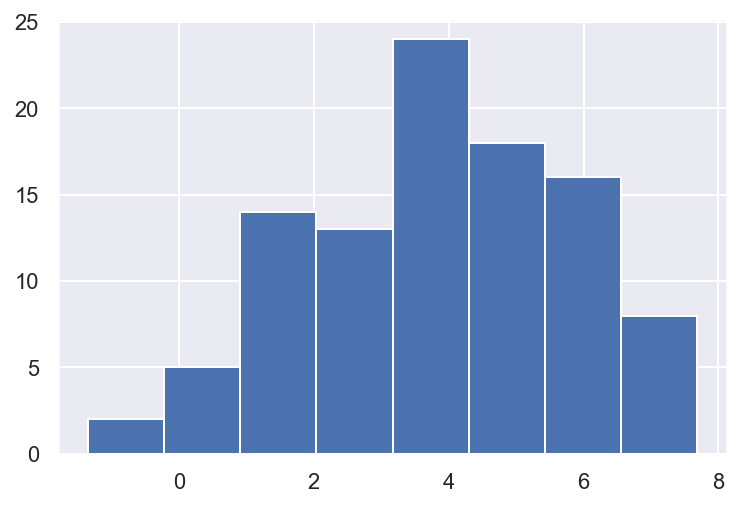

In [192]:
fig, ax = plt.subplots()
ax.hist(obs.data.numpy(), bins='auto');

# Full batch

In [193]:
def train_full_batch(
        obs,
        epochs=1000,
        initial_lr=0.01,
        freq_update_loss=50):

    model = Model()
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=initial_lr)

    hist_loss = []
    hist_mu = []
    hist_log_var = []

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):

            optimizer.zero_grad()
            loss = model(obs=obs)
            loss.backward()
            optimizer.step()

            hist_loss.append(loss.item())
            hist_mu.append(model.mu.item())
            hist_log_var.append(model.log_var.item())

            if i % freq_update_loss == 0 and i > 0:
                pbar.set_postfix(
                    {'loss': np.mean(hist_loss[i - freq_update_loss:i])})
            pbar.update()

    return model, hist_loss, hist_mu, hist_log_var

In [194]:
model, hist_loss, hist_mu, hist_log_var = train_full_batch(obs, initial_lr=0.1)

  0%|          | 0/1000 [00:00<?, ?it/s]

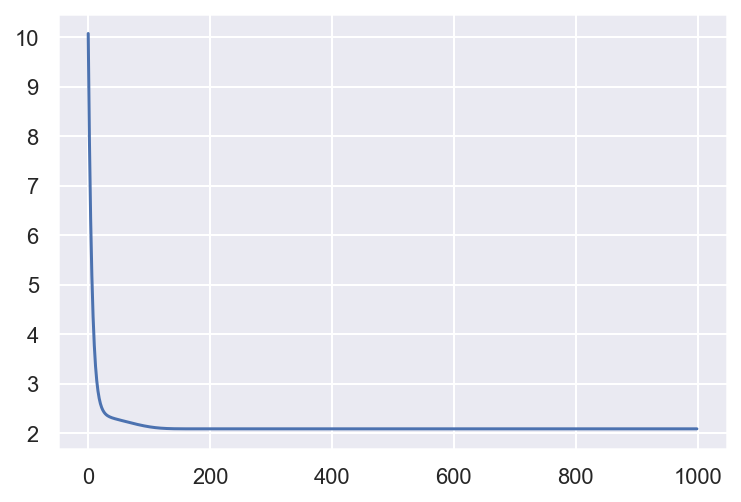

In [195]:
plt.plot(hist_loss);

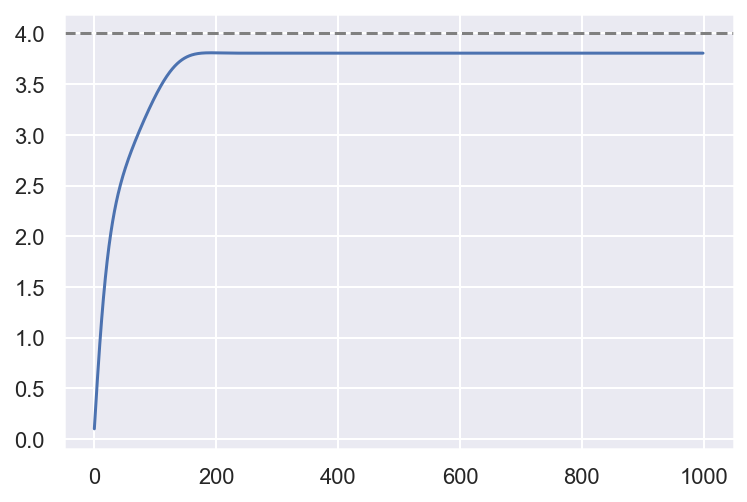

In [196]:
fig, ax = plt.subplots()
ax.plot(hist_mu)
ax.axhline(true_mu, ls='--', color='.50');

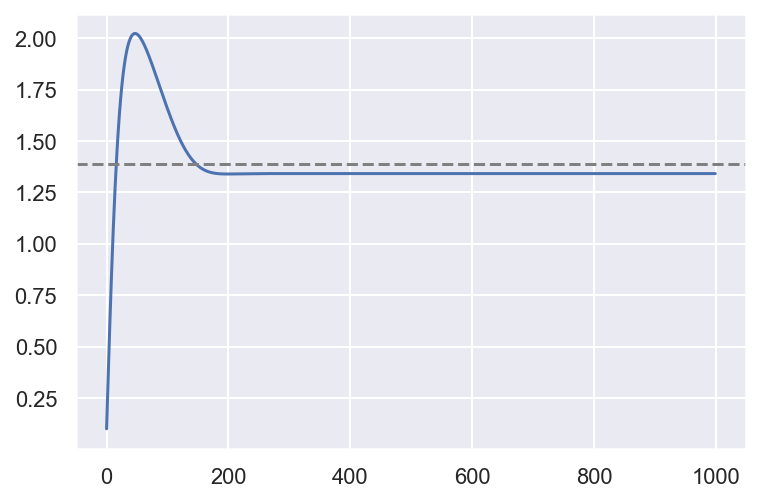

In [197]:
fig, ax = plt.subplots()
ax.plot(hist_log_var)
ax.axhline(np.log(true_sigma**2), ls='--', color='.50');

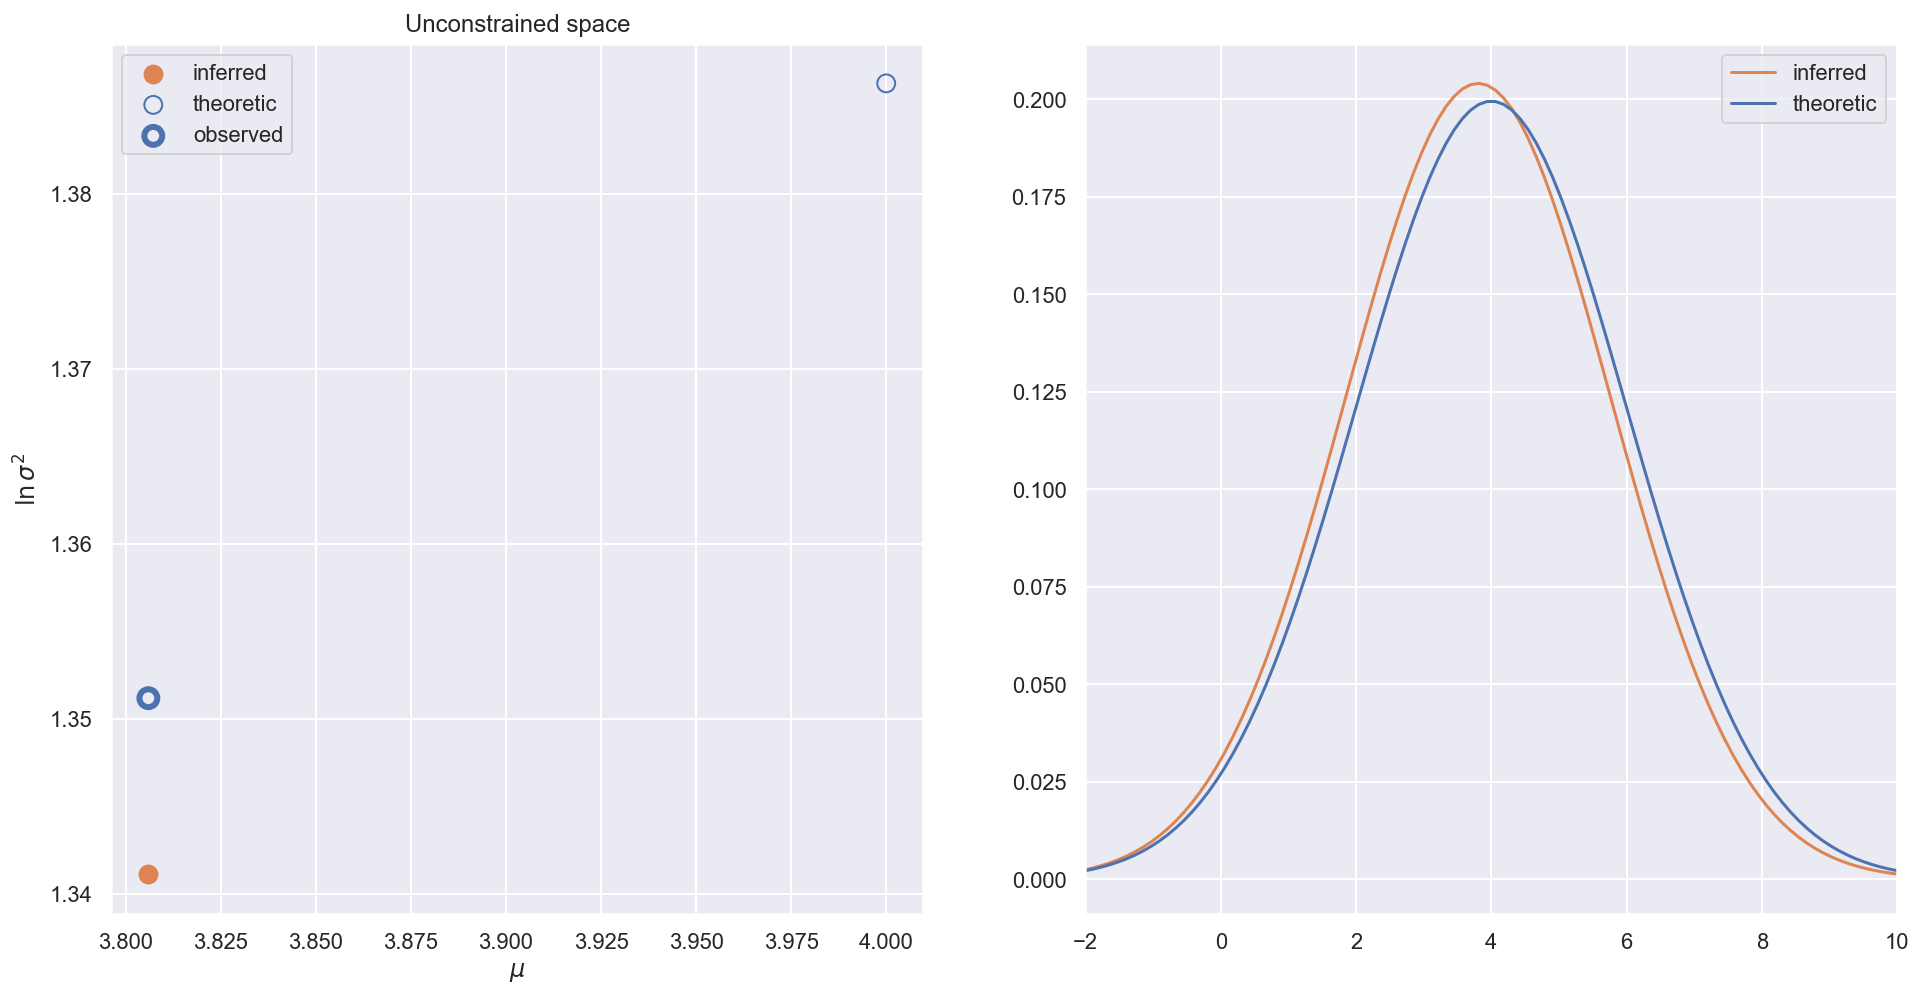

In [198]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=torch.tensor(hist_mu[-1]), 
    log_var_samples=torch.tensor(hist_log_var[-1]))

# Minibatch

In [199]:
def train_minibatch(obs, batch_size=10, epochs=1000, 
                    initial_lr=0.005, seed=123):
    
    torch.manual_seed(seed)

    model = Model()
    
    optimizer = optim.Adam(
        model.parameters(),
        lr=initial_lr)

    hist_loss = []
    hist_mu = []
    hist_log_var = []

    with tqdm(total=epochs) as pbar:

        for i in range(epochs):
            
            permutation = torch.randperm(n_obs)

            for i in range(0, n_obs, batch_size):
                
                indices = permutation[i:i+batch_size]
                minibatch = obs[indices]

                optimizer.zero_grad()
                loss = model(obs=minibatch)
                loss.backward()
                optimizer.step()

                hist_loss.append(loss.item())
                hist_mu.append(model.mu.item())
                hist_log_var.append(model.log_var.item())

                pbar.set_postfix(loss=loss.item())
            pbar.update()

    return model, hist_loss, hist_mu, hist_log_var

In [200]:
batch_size = 10
flow, hist_loss, hist_mu, hist_log_var = train_minibatch(
    obs, 
    batch_size=batch_size)

  0%|          | 0/1000 [00:00<?, ?it/s]

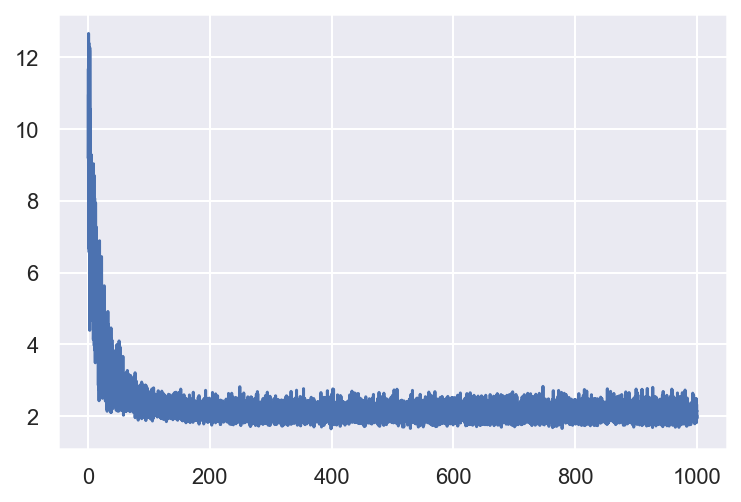

In [201]:
plt.plot(np.arange(len(hist_loss)) / batch_size, hist_loss);

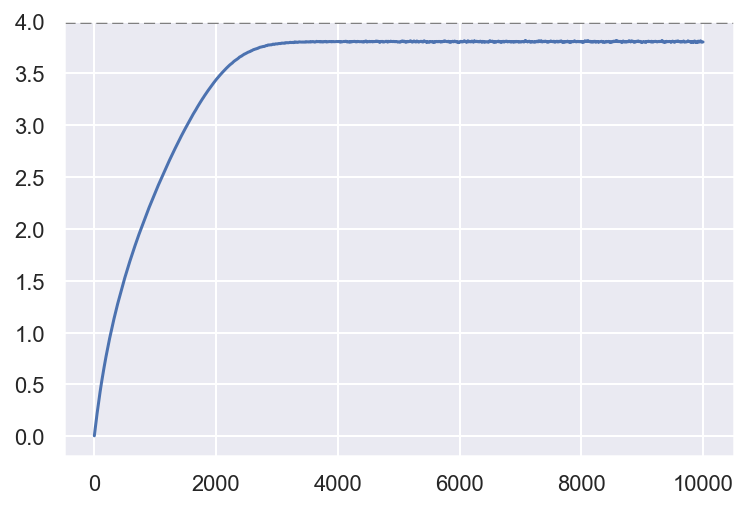

In [202]:
fig, ax = plt.subplots()
ax.plot(hist_mu)
ax.axhline(true_mu, ls='--', color='.50');

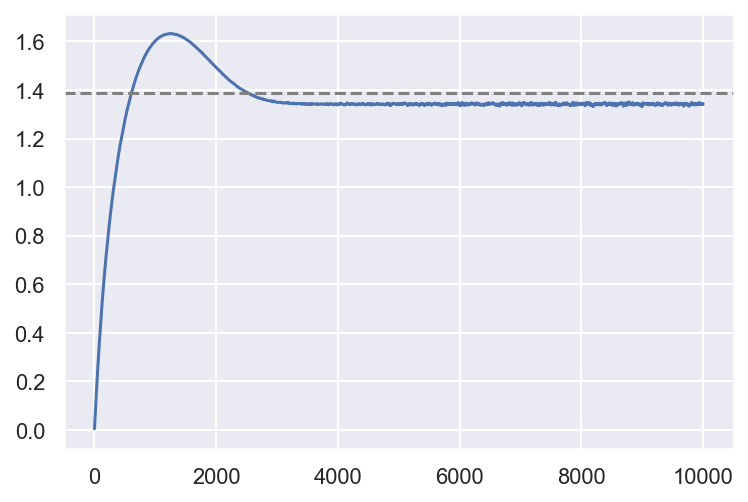

In [203]:
fig, ax = plt.subplots()
ax.plot(hist_log_var)
ax.axhline(np.log(true_sigma**2), ls='--', color='.50');

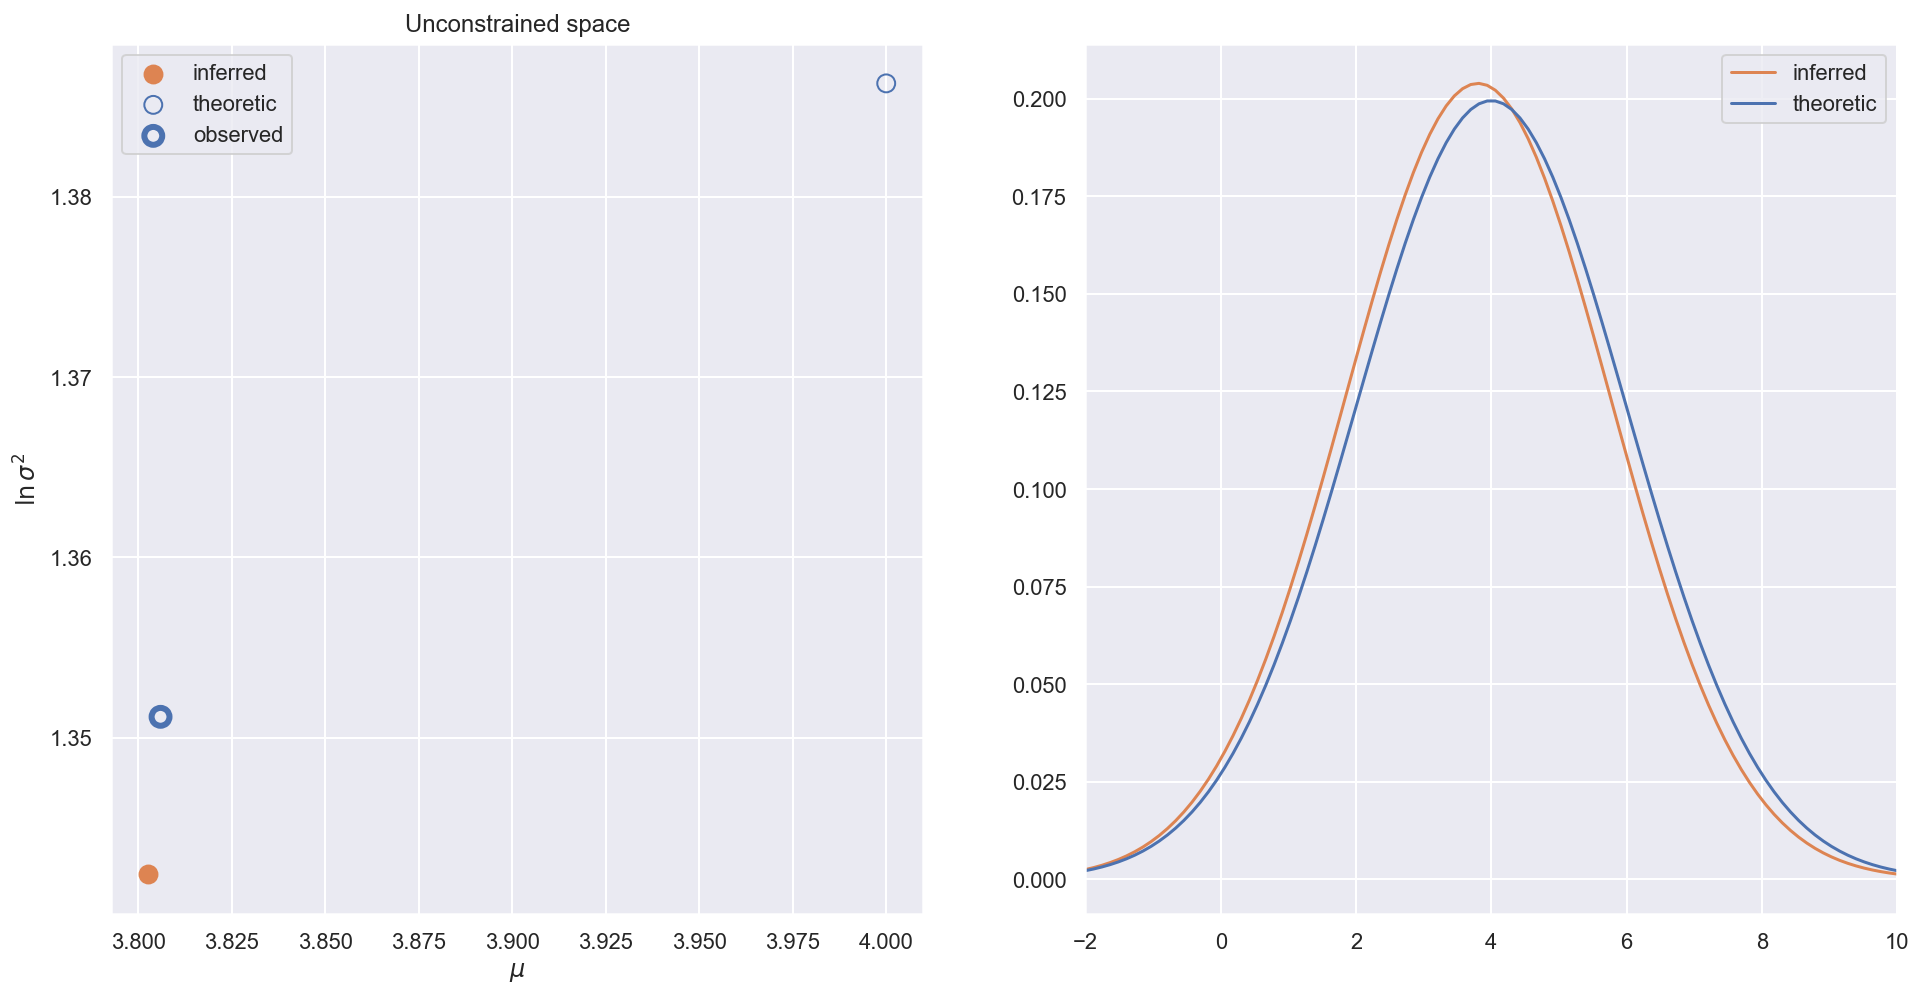

In [204]:
plot_results(
    true_mu=true_mu, true_sigma=true_sigma, 
    obs_mu=obs_mu, obs_sigma=obs_sigma, 
    mu_samples=torch.tensor(hist_mu[-1]), 
    log_var_samples=torch.tensor(hist_log_var[-1]))